In [66]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [67]:
AUDIO_DIR = 'audio'
SPEC_DIR = 'spec_images'
META_PATH = 'metadata.csv'

WINDOW_SIZE = 3.0  # seconds
HOP_SIZE = 1.5     # seconds
SR = 22050         # sampling rate
IMG_SIZE = 128     # spectrogram image size


In [68]:
def add_noise(y, noise_factor=0.005):
    """Adds random Gaussian noise to an audio signal."""
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(y[0]))
    return augmented_data

def time_shift(y, sr, shift_max_ms=100):
    """Shifts an audio signal in time."""
    shift = int(sr * shift_max_ms / 1000 * np.random.uniform(-1, 1))
    return np.roll(y, shift)

def pitch_shift(y, sr, n_steps=2):
    """Shifts the pitch of an audio signal."""
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

In [69]:
os.makedirs(SPEC_DIR, exist_ok=True)
meta_df = pd.read_csv(META_PATH)  # columns: filename,label

label_map = {label: idx for idx, label in enumerate(meta_df['diagnosis'].unique())}
label_df = meta_df.set_index('id')['diagnosis'].to_dict()

def save_spec_patch(y, sr, out_path):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_img = Image.fromarray(S_dB).resize((IMG_SIZE, IMG_SIZE))
    S_img = S_img.convert('L')  # grayscale
    S_img.save(out_path)

# Loop through each audio file
for fname in tqdm(os.listdir(AUDIO_DIR)):
    if not fname.endswith('.wav'):
        continue

    file_id = os.path.splitext(fname)[0]
    
    # Load the original audio file
    y, sr = librosa.load(os.path.join(AUDIO_DIR, fname), sr=SR)
    
    # Create a dictionary of augmented audio signals
    # Each key will be used to name the output files
    augmented_audios = {
        "original": y,
        "noise": add_noise(y, noise_factor=0.005),
        "shift": time_shift(y, sr, shift_max_ms=100),
        "pitch": pitch_shift(y, sr, n_steps=2)
    }

    # Process each augmented version (and the original)
    for aug_type, aug_y in augmented_audios.items():
        duration = librosa.get_duration(y=aug_y, sr=sr)
        
        win_len = int(WINDOW_SIZE * SR)
        hop_len = int(HOP_SIZE * SR)
        
        # The output directory is the same for all versions of a file
        output_dir = os.path.join(SPEC_DIR, file_id)
        os.makedirs(output_dir, exist_ok=True)

        # Create spectrogram patches for the current audio version
        for i, start in enumerate(np.arange(0, duration - WINDOW_SIZE, HOP_SIZE)):
            s = int(start * SR)
            y_win = aug_y[s : s + win_len]
            
            # Add the augmentation type to the output filename
            out_path = os.path.join(output_dir, f"{file_id}_{aug_type}_{i}.png")
            save_spec_patch(y_win, sr, out_path)



100%|██████████| 1843/1843 [11:07<00:00,  2.76it/s]


In [70]:
# Create a DataFrame to track the number of patches per class
patch_counts = {}
for label in label_map.keys():
    patch_counts[label] = len([f for f in os.listdir(os.path.join(SPEC_DIR, label)) if f.endswith('.png')]) 
df = pd.DataFrame({
    'label': list(patch_counts.keys()),
    'num_patches': list(patch_counts.values())
})
print("\nDataFrame of patch counts:")
print(df)

FileNotFoundError: [Errno 2] No such file or directory: 'spec_images/URTI'

In [71]:
class SpecPatchDataset(Dataset):
    def __init__(self, root_dir, file_ids_to_load, patient_to_diagnosis_map, diagnosis_to_int_map, transform=None):
        """
        Args:
            root_dir (string): Directory with all the spectrogram sub-folders.
            file_ids_to_load (list): List of specific .wav filenames to load (e.g., train_ids or val_ids).
            patient_to_diagnosis_map (dict): Maps patient ID (int) to diagnosis (str).
            diagnosis_to_int_map (dict): Maps diagnosis (str) to a class index (int).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.samples = []
        self.labels = []
        self.transform = transform or transforms.ToTensor()
        
        # Loop over only the file IDs we're supposed to load
        for file_name in file_ids_to_load:
            file_id_without_ext = os.path.splitext(file_name)[0]
            
            # Extract patient ID to get the correct label
            patient_id = int(file_name.split('_')[0])
            class_label_str = patient_to_diagnosis_map[patient_id]
            label_idx = diagnosis_to_int_map[class_label_str]
            
            # Find all spectrogram patches for this audio file
            spectrogram_folder = os.path.join(root_dir, file_id_without_ext)
            if os.path.isdir(spectrogram_folder):
                for img_name in os.listdir(spectrogram_folder):
                    self.samples.append(os.path.join(spectrogram_folder, img_name))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('L')
        img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [72]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # We define the feature extractor part of the model separately
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # To find the input size for the linear layer, we pass a dummy tensor
        # through the feature extractor once.
        with torch.no_grad():
            # Create a dummy tensor with the same dimensions as one input image
            dummy_input = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
            # Pass it through the feature extractor
            dummy_output = self.features(dummy_input)
            # Get the size of the flattened output
            flattened_size = dummy_output.view(1, -1).size(1)
            
        # Now we can define the classifier with the correct input size
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Pass input through the feature extractor
        x = self.features(x)
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)
        # Pass the flattened tensor through the classifier
        x = self.classifier(x)
        return x

In [73]:
print(meta_df['diagnosis'].value_counts())

diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64


In [74]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 1. Identify and filter out classes with fewer than 2 samples
class_counts = meta_df['diagnosis'].value_counts()
classes_to_remove = class_counts[class_counts < 2].index.tolist()

if classes_to_remove:
    print(f"Removing rare classes: {classes_to_remove}")
    ids_to_remove = meta_df[meta_df['diagnosis'].isin(classes_to_remove)]['id'].astype(str).tolist()
    all_file_ids = [f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')]
    file_ids = [f for f in all_file_ids if f.split('_')[0] not in ids_to_remove]
else:
    file_ids = [f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')]

# 2. Create labels for the filtered files for stratification
patient_ids = [int(f.split('_')[0]) for f in file_ids]
stratify_labels = [meta_df.loc[meta_df['id'] == pid, 'diagnosis'].values[0] for pid in patient_ids]

# 3. Split the filtered data
train_ids, val_ids = train_test_split(
    file_ids,
    test_size=0.2,
    stratify=stratify_labels,
    random_state=42
)

# 4. Define the necessary dictionaries for the dataset
# This maps patient ID (e.g., 101) to diagnosis (e.g., 'COPD')
patient_to_diagnosis_map = meta_df.set_index('id')['diagnosis'].to_dict()
# This maps diagnosis (e.g., 'COPD') to an integer (e.g., 0)
diagnosis_to_int_map = {label: idx for idx, label in enumerate(meta_df['diagnosis'].unique())}

# 5. Instantiate the datasets using the corrected class
train_ds = SpecPatchDataset(SPEC_DIR, train_ids, patient_to_diagnosis_map, diagnosis_to_int_map, transform)
val_ds   = SpecPatchDataset(SPEC_DIR, val_ids, patient_to_diagnosis_map, diagnosis_to_int_map, transform)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

print(f"\\nTraining spectrogram patches: {len(train_ds)}")
print(f"Validation spectrogram patches: {len(val_ds)}")

Removing rare classes: ['Asthma']
\nTraining spectrogram patches: 37724
Validation spectrogram patches: 9976


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(label_map)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 30):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss / len(train_loader):.4f}")


Epoch 01 | Train Loss: 0.6161
Epoch 02 | Train Loss: 0.6016
Epoch 03 | Train Loss: 0.6018
Epoch 04 | Train Loss: 0.5995
Epoch 05 | Train Loss: 0.5987
Epoch 06 | Train Loss: 0.5966
Epoch 07 | Train Loss: 0.5961
Epoch 08 | Train Loss: 0.5961
Epoch 09 | Train Loss: 0.5949
Epoch 10 | Train Loss: 0.5935
Epoch 11 | Train Loss: 0.5930
Epoch 12 | Train Loss: 0.5929
Epoch 13 | Train Loss: 0.5923
Epoch 14 | Train Loss: 0.5922
Epoch 15 | Train Loss: 0.5915
Epoch 16 | Train Loss: 0.5912
Epoch 17 | Train Loss: 0.5911
Epoch 18 | Train Loss: 0.5901
Epoch 19 | Train Loss: 0.5904
Epoch 20 | Train Loss: 0.5904
Epoch 21 | Train Loss: 0.5902
Epoch 22 | Train Loss: 0.5902
Epoch 23 | Train Loss: 0.5905
Epoch 24 | Train Loss: 0.5900
Epoch 25 | Train Loss: 0.5897
Epoch 26 | Train Loss: 0.5896
Epoch 27 | Train Loss: 0.5901
Epoch 28 | Train Loss: 0.5893
Epoch 29 | Train Loss: 0.5898


In [76]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {correct / total:.4f}")


Validation Accuracy: 0.8797


In [77]:
#MLP version
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Calculate the input size from the image dimensions
        input_size = IMG_SIZE * IMG_SIZE

        # Define the sequence of layers
        self.layers = nn.Sequential(
            # This layer flattens the 2D image into a 1D vector
            nn.Flatten(),
            
            # First hidden layer
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Second hidden layer
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Output layer
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """The forward pass."""
        return self.layers(x)

In [78]:
# Make sure you have defined the MLP class in a cell above this one

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the new MLP model
model = MLP(num_classes=len(label_map)).to(device)

print("Using MLP model:")
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 16):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss / len(train_loader):.4f}")

Using MLP model:
MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=256, out_features=8, bias=True)
  )
)
Epoch 01 | Train Loss: 0.6810
Epoch 02 | Train Loss: 0.6133
Epoch 03 | Train Loss: 0.6110
Epoch 04 | Train Loss: 0.6076
Epoch 05 | Train Loss: 0.6055
Epoch 06 | Train Loss: 0.5963
Epoch 07 | Train Loss: 0.5910
Epoch 08 | Train Loss: 0.5910
Epoch 09 | Train Loss: 0.5908
Epoch 10 | Train Loss: 0.5913
Epoch 11 | Train Loss: 0.5908
Epoch 12 | Train Loss: 0.5911
Epoch 13 | Train Loss: 0.5904
Epoch 14 | Train Loss: 0.5901
Epoch 15 | Train Loss: 0.5903


In [79]:
# Model Evaluation for MLP
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"MLP Validation Accuracy: {correct / total:.4f}")



MLP Validation Accuracy: 0.8797


In [80]:
# --- Verify the class distribution in the validation set patches ---
import pandas as pd

val_labels = []
# Loop through the val_loader to get all patch labels
for _, labels in val_loader:
    val_labels.extend(labels.cpu().numpy())

# Create a reverse mapping from index to class name
idx_to_class = {v: k for k, v in diagnosis_to_int_map.items()}
val_class_names = [idx_to_class[i] for i in val_labels]

print("Class distribution of validation set patches:")
print(pd.Series(val_class_names).value_counts(normalize=True))

Class distribution of validation set patches:
COPD              0.879711
Healthy           0.033681
Pneumonia         0.033681
URTI              0.024058
Bronchiolitis     0.014435
Bronchiectasis    0.014435
Name: proportion, dtype: float64


In [81]:
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Calculate Class Weights ---
# Get the distribution of all training patches to calculate weights
train_labels_for_weights = []
for _, labels in train_loader:
    train_labels_for_weights.extend(labels.numpy())

# Calculate weights: the inverse of the class frequency, which penalizes the model
# more for making mistakes on rare classes.
class_counts = np.bincount(train_labels_for_weights)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# Move weights to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)


# --- 2. Train the MLP Model with Weighted Loss ---
# Re-initialize the model to ensure you're training a fresh one
model = MLP(num_classes=len(label_map)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Tell the loss function to use the calculated weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("--- Starting Training with Weighted Loss ---")
for epoch in range(1, 51): # You can increase epochs for better convergence
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss / len(train_loader):.4f}")



--- Starting Training with Weighted Loss ---
Epoch 01 | Train Loss: 1.9511
Epoch 02 | Train Loss: 1.9354
Epoch 03 | Train Loss: 1.9350
Epoch 04 | Train Loss: 1.9184
Epoch 05 | Train Loss: 1.9118
Epoch 06 | Train Loss: 1.8998
Epoch 07 | Train Loss: 1.9008
Epoch 08 | Train Loss: 1.8974
Epoch 09 | Train Loss: 1.8980
Epoch 10 | Train Loss: 1.8963
Epoch 11 | Train Loss: 1.8999
Epoch 12 | Train Loss: 1.8969
Epoch 13 | Train Loss: 1.8956
Epoch 14 | Train Loss: 1.8954
Epoch 15 | Train Loss: 1.8954
Epoch 16 | Train Loss: 1.8974
Epoch 17 | Train Loss: 1.8930
Epoch 18 | Train Loss: 1.8985
Epoch 19 | Train Loss: 1.8961
Epoch 20 | Train Loss: 1.8986
Epoch 21 | Train Loss: 1.8983
Epoch 22 | Train Loss: 1.8950
Epoch 23 | Train Loss: 1.8981
Epoch 24 | Train Loss: 1.8955
Epoch 25 | Train Loss: 1.8930
Epoch 26 | Train Loss: 1.8944
Epoch 27 | Train Loss: 1.8977
Epoch 28 | Train Loss: 1.8914
Epoch 29 | Train Loss: 1.8945
Epoch 30 | Train Loss: 1.8975
Epoch 31 | Train Loss: 1.8964
Epoch 32 | Train Loss: 1.

In [82]:

# --- 3. Evaluate the NEWLY Trained Model ---
print("\n--- Evaluating Model Trained with Weighted Loss ---")
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        y_true.extend(labels.cpu().numpy())
        
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())

# Overall Accuracy
correct = (np.array(y_pred) == np.array(y_true)).sum()
total = len(y_true)
print(f"\nValidation Accuracy: {100 * correct / total:.2f}%\n")



--- Evaluating Model Trained with Weighted Loss ---

Validation Accuracy: 87.97%



Classification Report:
                precision    recall  f1-score   support

          URTI       0.00      0.00      0.00       240
       Healthy       0.00      0.00      0.00       336
          COPD       0.88      1.00      0.94      8776
Bronchiectasis       0.00      0.00      0.00       144
     Pneumonia       0.00      0.00      0.00       336
 Bronchiolitis       0.00      0.00      0.00       144

      accuracy                           0.88      9976
     macro avg       0.15      0.17      0.16      9976
  weighted avg       0.77      0.88      0.82      9976

Confusion Matrix:


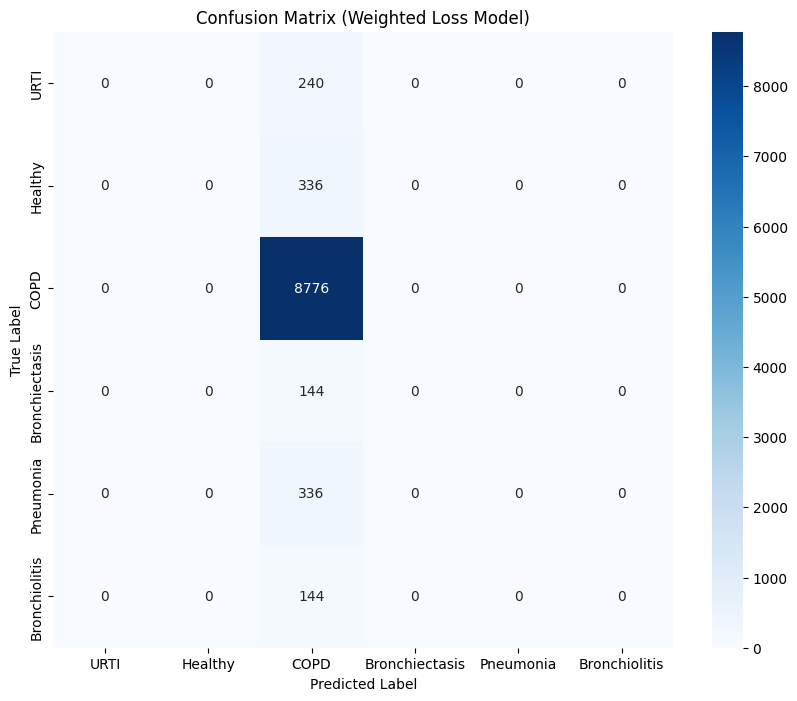

In [83]:

# Classification Report
print("Classification Report:")
idx_to_class = {v: k for k, v in diagnosis_to_int_map.items()}
present_class_indices = sorted(list(set(y_true)))
present_class_names = [idx_to_class[i] for i in present_class_indices]
report = classification_report(y_true, y_pred, labels=present_class_indices, target_names=present_class_names, zero_division=0)
print(report)

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred, labels=present_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=present_class_names, yticklabels=present_class_names)
plt.title('Confusion Matrix (Weighted Loss Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [84]:
import numpy as np
from tqdm import tqdm

# Initialize a dictionary to count patches per class
patch_counts = {label: 0 for label in label_map.keys()}

# Process each audio file
for fname in tqdm(os.listdir(AUDIO_DIR)):
    if not fname.endswith('.wav'):
        continue
    
    file_id = os.path.splitext(fname)[0]
    patient_id = int(fname.split('_')[0])
    
    # Get the label for this file
    label = patient_to_diagnosis_map[patient_id]
    
    # Skip if this is one of the rare classes we removed
    if label in classes_to_remove:
        continue
    
    # Calculate number of patches for this file
    y, _ = librosa.load(os.path.join(AUDIO_DIR, fname), sr=SR)
    duration = librosa.get_duration(y=y, sr=SR)
    
    if duration < WINDOW_SIZE:
        num_patches = 1  # at least one patch even if file is shorter than window
    else:
        num_patches = int(np.floor((duration - WINDOW_SIZE) / HOP_SIZE)) + 1
    
    patch_counts[label] += num_patches

# Display the results
print("Total spectrogram patches per class after sliding window segmentation:")
for label, count in patch_counts.items():
    print(f"{label:15s}: {count}")

100%|██████████| 1843/1843 [00:07<00:00, 245.35it/s]

Total spectrogram patches per class after sliding window segmentation:
URTI           : 276
Healthy        : 420
Asthma         : 0
COPD           : 10420
LRTI           : 24
Bronchiectasis : 192
Pneumonia      : 444
Bronchiolitis  : 156


In [85]:
df = pd.DataFrame({
    'label': list(patch_counts.keys()),
    'num_patches': list(patch_counts.values())
})
print("\nDataFrame of patch counts:")
print(df)


DataFrame of patch counts:
            label  num_patches
0            URTI          276
1         Healthy          420
2          Asthma            0
3            COPD        10420
4            LRTI           24
5  Bronchiectasis          192
6       Pneumonia          444
7   Bronchiolitis          156


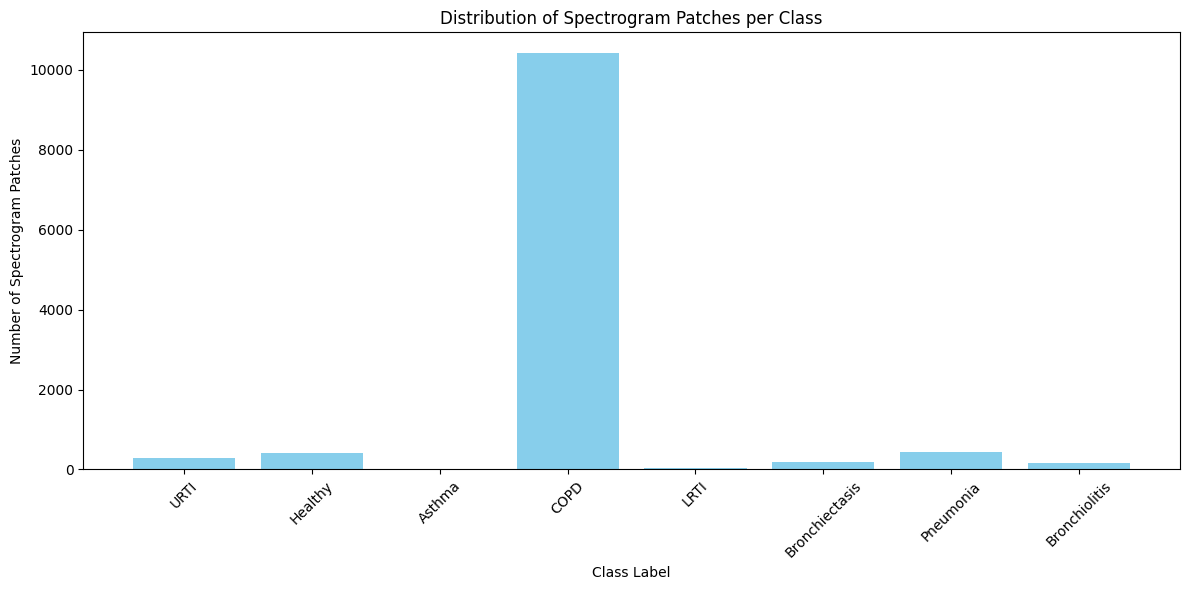

In [86]:
import matplotlib.pyplot as plt
# Plot the distribution of spectrogram patches per class
plt.figure(figsize=(12, 6))
plt.bar(df['label'], df['num_patches'], color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Spectrogram Patches')
plt.title('Distribution of Spectrogram Patches per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [89]:
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import WeightedRandomSampler

# --- 1. Calculate Class Weights for the Loss Function ---
# (This part is the same as before)
train_labels_for_weights = []
for _, labels in train_ds: # Using the augmented training dataset
    train_labels_for_weights.append(labels)

class_counts = np.bincount(train_labels_for_weights)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)


# --- 2. Create Weights for the Sampler ---
# The sampler needs a weight for every single sample in the training set.
train_samples_weights = [class_weights[label] for label in train_labels_for_weights]
sampler = WeightedRandomSampler(weights=train_samples_weights, num_samples=len(train_samples_weights), replacement=True)


# --- 3. Update the DataLoader to use the Sampler ---
# IMPORTANT: When using a sampler, you must set shuffle=False.
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False) # Validation loader remains the same


# --- 4. Train the MLP Model ---
model = SimpleCNN(num_classes=len(label_map)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("--- Starting Training with SAMPLER and Weighted Loss ---")
for epoch in range(1, 31):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss / len(train_loader):.4f}")


--- Starting Training with SAMPLER and Weighted Loss ---
Epoch 01 | Train Loss: 1.3659
Epoch 02 | Train Loss: 1.3395
Epoch 03 | Train Loss: 1.3309
Epoch 04 | Train Loss: 1.3129
Epoch 05 | Train Loss: 1.3142
Epoch 06 | Train Loss: 1.3300
Epoch 07 | Train Loss: 1.3248
Epoch 08 | Train Loss: 1.3148
Epoch 09 | Train Loss: 1.3023
Epoch 10 | Train Loss: 1.3193
Epoch 11 | Train Loss: 1.3082
Epoch 12 | Train Loss: 1.3208
Epoch 13 | Train Loss: 1.3220
Epoch 14 | Train Loss: 1.3221
Epoch 15 | Train Loss: 1.3294
Epoch 16 | Train Loss: 1.3109
Epoch 17 | Train Loss: 1.3158
Epoch 18 | Train Loss: 1.3059
Epoch 19 | Train Loss: 1.3153
Epoch 20 | Train Loss: 1.3153
Epoch 21 | Train Loss: 1.3034
Epoch 22 | Train Loss: 1.3225
Epoch 23 | Train Loss: 1.3122
Epoch 24 | Train Loss: 1.3190
Epoch 25 | Train Loss: 1.3286
Epoch 26 | Train Loss: 1.3125
Epoch 27 | Train Loss: 1.3142
Epoch 28 | Train Loss: 1.3139
Epoch 29 | Train Loss: 1.3061
Epoch 30 | Train Loss: 1.3253



--- Evaluating Final Model ---

Final Validation Accuracy: 0.00%

Final Classification Report:
                precision    recall  f1-score   support

          URTI       0.00      0.00      0.00     240.0
       Healthy       0.00      0.00      0.00     336.0
          COPD       0.00      0.00      0.00    8776.0
Bronchiectasis       0.00      0.00      0.00     144.0
     Pneumonia       0.00      0.00      0.00     336.0
 Bronchiolitis       0.00      0.00      0.00     144.0

     micro avg       0.00      0.00      0.00    9976.0
     macro avg       0.00      0.00      0.00    9976.0
  weighted avg       0.00      0.00      0.00    9976.0


Final Confusion Matrix:


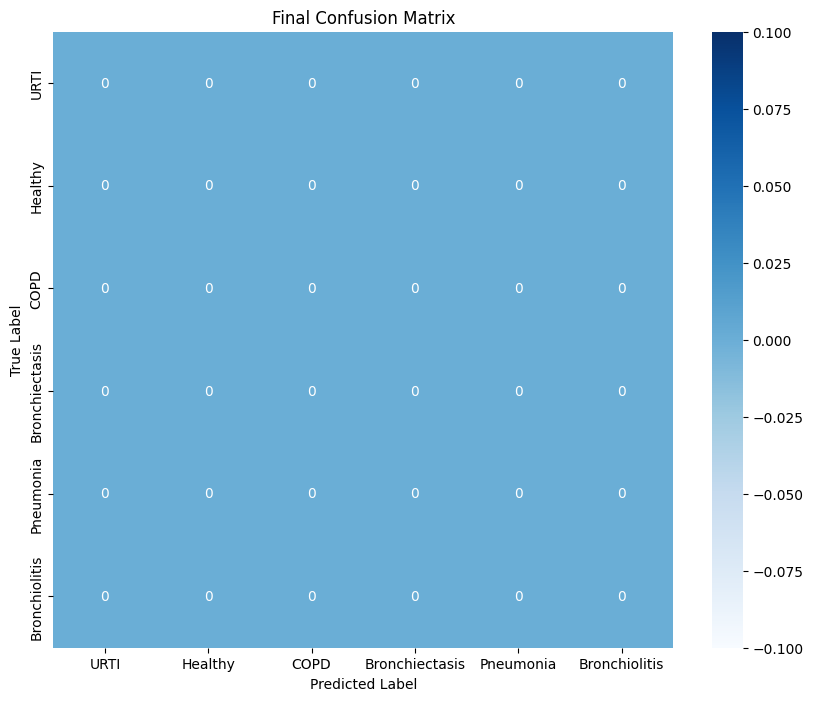

In [90]:
# --- 5. Evaluate the Final Model ---
print("\n--- Evaluating Final Model ---")
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        y_true.extend(labels.cpu().numpy())
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())

# Final Metrics
correct = (np.array(y_pred) == np.array(y_true)).sum()
total = len(y_true)
print(f"\nFinal Validation Accuracy: {100 * correct / total:.2f}%\n")
print("Final Classification Report:")
idx_to_class = {v: k for k, v in diagnosis_to_int_map.items()}
present_class_indices = sorted(list(set(y_true)))
present_class_names = [idx_to_class[i] for i in present_class_indices]
report = classification_report(y_true, y_pred, labels=present_class_indices, target_names=present_class_names, zero_division=0)
print(report)
print("\nFinal Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred, labels=present_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=present_class_names, yticklabels=present_class_names)
plt.title('Final Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()